In [1]:
import yaml
import numpy as np
import plotly.express as ex

from preprocessing import filter_dataframe_by_bounding_box, prepare_data

from src.gpytorch_model import ExactGPModel
import gpytorch
import torch


kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel(lengthscale=0.75, lengthscale_constraint=gpytorch.constraints.Interval(0.5, 1), alpha=50, alpha_constraint=gpytorch.constraints.Interval(5, 100)))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
data = prepare_data(True)
training_stuff, val_stuff = data[0:4], data[4:-1]
len(training_stuff), len(val_stuff)

# init model for state dict loading
model = ExactGPModel(*[torch.tensor(i).float() for i in training_stuff], likelihood, kernel, 3, early_stopping_patience=5)
model.train_loop()
with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)


/home/justus/universität/ProbablisticML/ProbML/src/preprocessing.py:71: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CONFIG["data_file"], dtype=COLUMNS)
2023-07-03 18:37:19,567 - INFO - Sampling down to 10000 training points for reduced complexity


Iter 1/3 - Loss: 1.390  lengthscale: 0.750,  alpha: 52.500,  noise: 0.693  output scale: 0.693
test set results: loss: -1.352 likelihood: 25.7589 perc. mse: 0.857 rsquare: -7.356
Iter 2/3 - Loss: 1.388  lengthscale: 0.749,  alpha: 52.263,  noise: 0.698  output scale: 0.698
test set results: loss: -1.351 likelihood: 15.6779 perc. mse: 0.857 rsquare: -7.380
Iter 3/3 - Loss: 1.388  lengthscale: 0.747,  alpha: 52.025,  noise: 0.703  output scale: 0.703
test set results: loss: -1.350 likelihood: 29.1762 perc. mse: 0.856 rsquare: -7.397


In [2]:
from main import read_tristans_file
import matplotlib.pyplot as plt

centroids = read_tristans_file("data/centroids.txt")
centroids[0:5]

array([[12.42079905, 51.33769676],
       [12.37135549, 51.33424684],
       [12.37135549, 51.33424684],
       [12.49950692, 51.3481583 ],
       [12.37135549, 51.33424684]])

In [45]:
import pandas as pd
all_data = filter_dataframe_by_bounding_box( pd.read_csv("data/Prob_ml.csv"), *CONFIG["leipzig_bbox"].values())
out_mean = all_data["rsrp"].mean()
out_std = all_data["rsrp"].std()

lat_long_mean = all_data[["lon", "lat"]].mean().to_numpy()
lat_long_std = all_data[["lon", "lat"]].std().to_numpy()

print(lat_long_mean, lat_long_std)


[12.38268425 51.339412  ] [0.06173373 0.03206936]


/tmp/ipykernel_42601/4070079562.py:2: DtypeWarning:

Columns (1,2,3,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [48]:
means_ = all_data.groupby(["lon", "lat"])["rsrp"].mean()
stds_ = all_data.groupby(["lon", "lat"])["rsrp"].std()

In [55]:
print(means_.head())

lon        lat      
12.236690  51.291718   -117.0
12.236701  51.291860   -115.5
12.236731  51.292280   -104.0
12.236740  51.292420   -104.0
12.236770  51.391506   -115.0
Name: rsrp, dtype: float64


In [59]:
print(len(means_), len(all_data), stds_.mean())

45882 194821 4.482533862516876


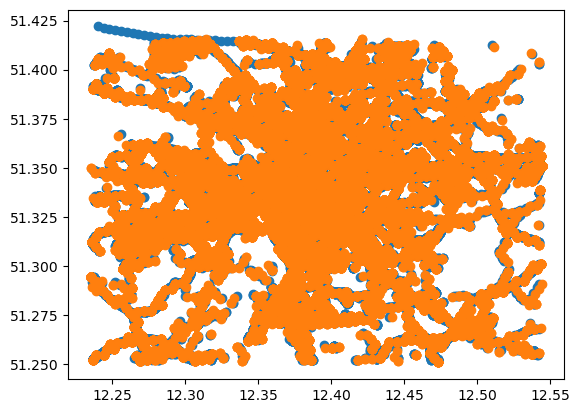

In [4]:
%matplotlib inline
plt.scatter(*all_data[["lon", "lat"]].to_numpy().T)
plt.scatter(centroids[:,0], centroids[:,1])

plt.show()

In [5]:
means = centroids.mean(axis=0)
sigs = centroids.std(axis=0)
means, sigs

(array([12.38268151, 51.33933159]), array([0.06184446, 0.03211983]))

In [6]:
centroids

array([[12.42079905, 51.33769676],
       [12.37135549, 51.33424684],
       [12.37135549, 51.33424684],
       ...,
       [12.3003568 , 51.32173423],
       [12.3003568 , 51.32173423],
       [12.3695451 , 51.3265988 ]])

In [7]:
centroids_std = (centroids -lat_long_mean)/ lat_long_std

centroids_std

array([[ 0.61740637, -0.05348507],
       [-0.18350998, -0.16106194],
       [-0.18350998, -0.16106194],
       ...,
       [-1.33358929, -0.55123538],
       [-1.33358929, -0.55123538],
       [-0.21283582, -0.3995464 ]])

In [37]:
import tqdm
# Split centroids_std into smaller batches, cubic memory complexity makes this necessary.
batch_size = 400
centroids_batches = [centroids_std[i:i + batch_size] for i in range(0, len(centroids_std), batch_size)]

# Create an empty list to store the predictions
predictions = []
predicted_variances = []

# Set the model to evaluation mode
model.eval()

# Iterate over each batch and predict the outputs
with torch.no_grad():
    for batch in tqdm.tqdm(centroids_batches):
        # Convert the batch to a tensor and feed it to the model
        batch_tensor = torch.tensor(batch).float()
        batch_preds = model(batch_tensor)
        predictions.append(batch_preds.mean.detach().numpy())
        predicted_variances.append(batch_preds.variance.detach().numpy())

# Concatenate the predictions from all batches into a single array
standardized_preds = np.concatenate(predictions)

# Print the resulting predictions
print(standardized_preds)

  1%|▏         | 7/485 [00:21<23:59,  3.01s/it]/home/justus/universität/ProbablisticML/ProbML/.conda/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

100%|██████████| 485/485 [25:45<00:00,  3.19s/it]

[-0.2601887   0.21140671  0.21140671 ... -0.08133556 -0.0813594
  0.05859341]


In [50]:
variances = np.concatenate(predicted_variances)

In [27]:
unstandardized_preds = (standardized_preds * out_std) + out_mean

In [15]:
centroids[:,0]

array([12.42079905, 12.37135549, 12.37135549, ..., 12.3003568 ,
       12.3003568 , 12.3695451 ])

In [52]:

pred_df =pd.DataFrame(np.array([centroids[:, 0], centroids[:, 1], unstandardized_preds, variances]).T, columns=["lon", "lat", "rsrp_hat", "var"])
pred_df.head()
pred_df.to_csv("output/predictions_for_tristan.csv")

In [53]:
import plotly.express as ex

fig = ex.scatter_3d(pred_df.sample(10000), x="lat", y="lon", z="rsrp_hat", color="var")
fig.show(renderer="browser")

In [40]:
fig = ex.scatter_3d(all_data, x="lat", y="lon", z="rsrp", color="rsrp")
fig.show(renderer='browser')